In [60]:
import pandas as pd
import numpy as np

# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Inspect missing values
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [61]:
import pandas as pd
import numpy as np

def step_1_data_cleaning(file_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # --- 1. HANDLE MISSING VALUES ---
    # Age: Impute based on Pclass and Sex medians (robust transformation)
    df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    
    # Embarked: Fill with the most frequent value (Mode)
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    # Fare: Fill missing with median
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # --- 2. FIX INCONSISTENCIES ---
    # Fare: Replace $0.0 values with the median of their Pclass
    df.loc[df['Fare'] <= 0, 'Fare'] = df.groupby('Pclass')['Fare'].transform('median')
    
    # Cabin: Standardize missing values to 'U' (Unknown) before feature creation
    df['Cabin'] = df['Cabin'].fillna('U')

    # --- 3. DATA TRANSFORMATION (Create New Features) ---
    # A. Extract Titles from Name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # B. Extract Deck from Cabin
    df['Deck'] = df['Cabin'].str[0]

    # C. Create FamilySize
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # D. Handle Sex Categorical (Binary transformation is standard for analysis)
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

    # --- UPDATED SECTION: DROP NON-NUMERIC COLUMNS ---
    # This removes the strings (like 'Name' and 'Ticket') that cause the Scaling error.
    df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True, errors='ignore')

    return df

# Execution
if __name__ == "__main__":
    # Clean train and test sets
    # Ensure train.csv and test.csv are in your current directory
    cleaned_train = step_1_data_cleaning('train.csv')
    cleaned_test = step_1_data_cleaning('test.csv')
    
    # Save cleaned files
    cleaned_train.to_csv('cleaned_train.csv', index=False)
    cleaned_test.to_csv('cleaned_test.csv', index=False)
    
    print("✅ Step 1 Complete: Missing values handled and features created.")
    print(f"Current columns available for Step 2: {list(cleaned_train.columns)}")

✅ Step 1 Complete: Missing values handled and features created.
Current columns available for Step 2: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Deck', 'FamilySize']


In [62]:
import pandas as pd
import os

def step_2_feature_engineering(input_path: str, output_path: str):
    # Check if file exists
    if not os.path.exists(input_path):
        print(f"❌ Error: {input_path} not found.")
        return None

    df = pd.read_csv(input_path)
    print(f"🔄 Processing {input_path}...")
    
    # --- 1. FAMILY SIZE ---
    if 'SibSp' in df.columns and 'Parch' in df.columns:
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # --- 2. EXTRACT TITLES ---
    if 'Name' in df.columns:
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
                                           'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
    else:
        df['Title'] = 'Unknown'

    # --- 3. ENCODING ---
    if 'Sex' in df.columns and df['Sex'].dtype == 'object':
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # Ensure Pclass is treated as a category
    if 'Pclass' in df.columns:
        df['Pclass'] = df['Pclass'].astype(str) 

    categorical_cols = ['Embarked', 'Pclass', 'Title', 'Deck']
    existing_cats = [col for col in categorical_cols if col in df.columns]
    
    # Generate Dummy Variables (One-Hot Encoding)
    df = pd.get_dummies(df, columns=existing_cats, drop_first=True)

    # --- 4. FINAL CLEANUP ---
    cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
    df_model = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Convert True/False from get_dummies into 1/0
    for col in df_model.select_dtypes(include=['bool']).columns:
        df_model[col] = df_model[col].astype(int)

    # Save the file
    df_model.to_csv(output_path, index=False)
    print(f"✅ Success! Saved featured data to: {output_path}")
    return df_model

# --- THIS IS THE PART THAT TRIGGER THE OUTPUT ---
# Run this for both Train and Test files
featured_train = step_2_feature_engineering('cleaned_train.csv', 'featured_train.csv')
featured_test = step_2_feature_engineering('cleaned_test.csv', 'featured_test.csv')

🔄 Processing cleaned_train.csv...
✅ Success! Saved featured data to: featured_train.csv
🔄 Processing cleaned_test.csv...
✅ Success! Saved featured data to: featured_test.csv


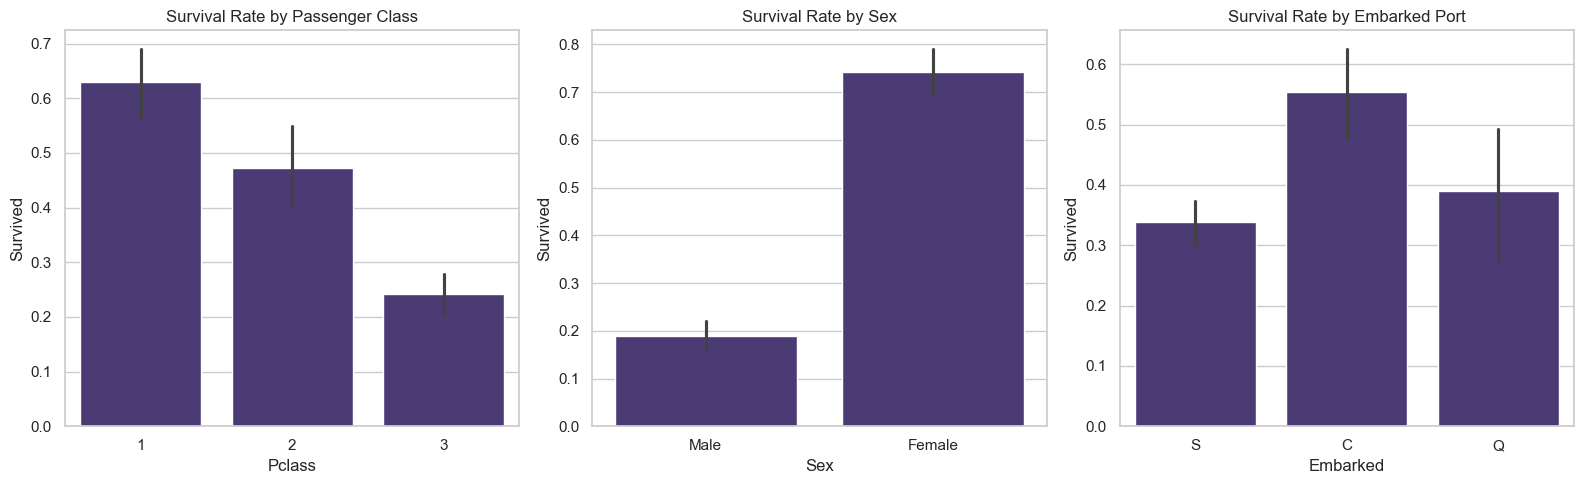

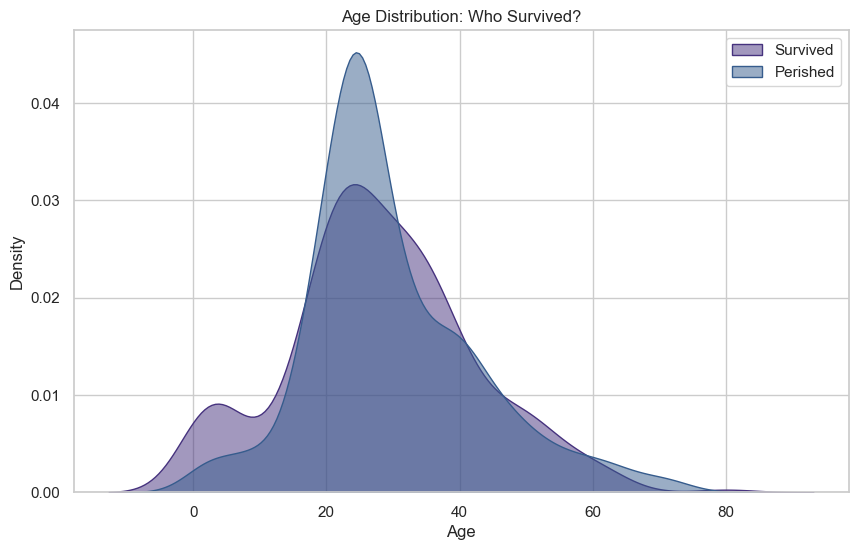

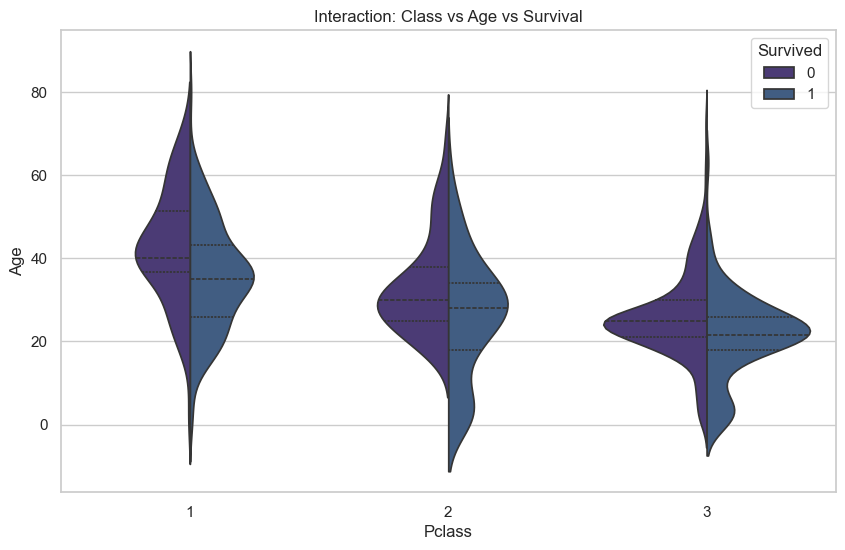

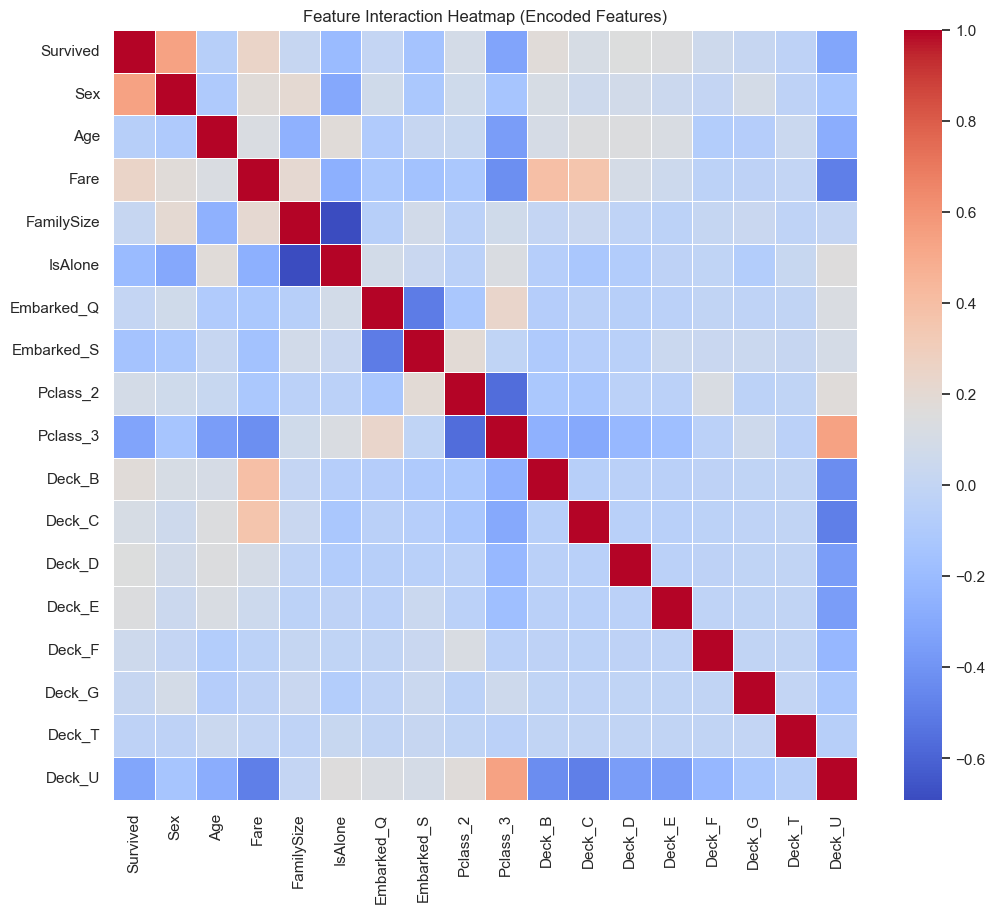


✅ EDA Complete. Visualizations saved as PNG files.

Top 5 Survival Correlations:
Survived    1.000000
Sex         0.543351
Fare        0.250635
Deck_B      0.175095
Deck_D      0.150716
Deck_E      0.145321
Name: Survived, dtype: float64


In [63]:
"""
Titanic Survival Prediction - Step 3: Exploratory Data Analysis (EDA)
Author: Saniya Uzma
Description: 
- Visualizes survival rates across categorical and numerical features.
- Investigates interactions between Age, Class, and Survival.
- Analyzes feature correlations using the engineered dataset.
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set aesthetic style for high-quality visuals
sns.set_theme(style="whitegrid", palette="viridis")

def run_eda():
    # Load the data from previous steps
    # We use 'cleaned_train' for plots with labels and 'featured_train' for correlation
    df_labels = pd.read_csv('cleaned_train.csv')
    df_encoded = pd.read_csv('featured_train.csv')

    # --- 1. SURVIVAL TRENDS (Class, Gender, Embarked) ---
    plt.figure(figsize=(16, 5))

    # Survival by Class
    plt.subplot(1, 3, 1)
    sns.barplot(x='Pclass', y='Survived', data=df_labels)
    plt.title('Survival Rate by Passenger Class')

    # Survival by Gender
    plt.subplot(1, 3, 2)
    # Mapping back to labels just for the plot if Sex was 0/1
    plot_sex = df_labels['Sex'].map({0: 'Male', 1: 'Female'})
    sns.barplot(x=plot_sex, y=df_labels['Survived'])
    plt.title('Survival Rate by Sex')

    # Survival by Embarked Port
    plt.subplot(1, 3, 3)
    sns.barplot(x='Embarked', y='Survived', data=df_labels)
    plt.title('Survival Rate by Embarked Port')

    plt.tight_layout()
    plt.savefig('survival_trends.png')
    plt.show()

    # --- 2. AGE VS SURVIVAL (Visualizing Patterns) ---
    plt.figure(figsize=(10, 6))
    # KDE plot shows the distribution density of age for survivors vs non-survivors
    sns.kdeplot(data=df_labels[df_labels['Survived'] == 1], x="Age", fill=True, label="Survived", alpha=0.5)
    sns.kdeplot(data=df_labels[df_labels['Survived'] == 0], x="Age", fill=True, label="Perished", alpha=0.5)
    plt.title('Age Distribution: Who Survived?')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('age_distribution_analysis.png')
    plt.show()

    # --- 3. FEATURE INTERACTIONS (Class vs Age vs Survival) ---
    plt.figure(figsize=(10, 6))
    # Violin plots show the distribution of age within each class, split by survival
    sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df_labels, split=True, inner="quart")
    plt.title('Interaction: Class vs Age vs Survival')
    plt.savefig('class_age_interaction.png')
    plt.show()

    # --- 4. CORRELATION HEATMAP (Interactions between all features) ---
    plt.figure(figsize=(12, 10))
    # We use the encoded data to see mathematical relationships
    correlation_matrix = df_encoded.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Interaction Heatmap (Encoded Features)')
    plt.savefig('correlation_heatmap.png')
    plt.show()

    # Print top survivors correlates
    print("\n✅ EDA Complete. Visualizations saved as PNG files.")
    print("\nTop 5 Survival Correlations:")
    print(correlation_matrix['Survived'].sort_values(ascending=False).head(6))

if __name__ == "__main__":
    run_eda()

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier

# 🔹 1. Load Data
df_model = pd.read_csv('featured_train.csv')

# 🔹 2. SAFETY CHECK: Encode any remaining strings
if df_model['Sex'].dtype == 'object':
    le = LabelEncoder()
    df_model['Sex'] = le.fit_transform(df_model['Sex'])

# 🔹 3. Prepare Features and Target
X = df_model.drop(columns=['Survived'], errors='ignore')
y = df_model['Survived']

# 🔹 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔹 5. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 6. Train the 5 Models (Updated XGBoost to remove warning)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42) # use_label_encoder removed
}

model_results = []

print("--- Training Models ---")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    model_results.append({"Model": name, "Accuracy": acc})
    print(f"Finished: {name}")

# 🔹 7. Display Results
results_df = pd.DataFrame(model_results).sort_values(by='Accuracy', ascending=False)
print("\n", results_df)

--- Training Models ---
Finished: Logistic Regression
Finished: Random Forest
Finished: SVM
Finished: KNN
Finished: XGBoost

                  Model  Accuracy
4              XGBoost  0.821229
0  Logistic Regression  0.804469
1        Random Forest  0.804469
2                  SVM  0.798883
3                  KNN  0.776536


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 🔹 1. Load Data
# Assuming you are using the output from your Step 2
df_model = pd.read_csv('featured_train.csv')

# 🔹 2. SAFETY CHECK: Encode any remaining strings (like 'male')
# If 'Sex' is still 'male'/'female', this turns it into 0/1
if df_model['Sex'].dtype == 'object':
    le = LabelEncoder()
    df_model['Sex'] = le.fit_transform(df_model['Sex'])

# 🔹 3. Prepare Features and Target
X = df_model.drop(columns=['Survived'], errors='ignore')
y = df_model['Survived']

# 🔹 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔹 5. Scale Features
# This will now work because all strings are gone!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 6. Train the 5 Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

model_results = []

print("--- Training Models ---")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    model_results.append({"Model": name, "Accuracy": acc})
    print(f"Finished: {name}")

# 🔹 7. Display Results
results_df = pd.DataFrame(model_results).sort_values(by='Accuracy', ascending=False)
print("\n", results_df)

--- Training Models ---
Finished: Logistic Regression
Finished: Random Forest
Finished: SVM
Finished: KNN
Finished: Gradient Boosting

                  Model  Accuracy
4    Gradient Boosting  0.832402
0  Logistic Regression  0.804469
1        Random Forest  0.804469
2                  SVM  0.798883
3                  KNN  0.776536


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import pandas as pd

# 🔹 1. Load Data
df_model = pd.read_csv('featured_train.csv')

# 🔹 2. SAFETY CHECK: Ensure numeric types for strings
if df_model['Sex'].dtype == 'object':
    le = LabelEncoder()
    df_model['Sex'] = le.fit_transform(df_model['Sex'])

# 🔹 3. Prepare Features and Target
X = df_model.drop(columns=['Survived'], errors='ignore')
y = df_model['Survived']

# 🔹 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔹 5. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 6. Initialize Models (Including both GB and XGB)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# 🔹 7. Training and Evaluation Loop
model_results = []

print("--- Training Models ---")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    model_results.append({"Model": name, "Accuracy": acc})
    print(f"Finished: {name}")

# 🔹 8. Display Final Comparison
results_df = pd.DataFrame(model_results).sort_values(by='Accuracy', ascending=False)
print("\n", results_df)

--- Training Models ---
Finished: Logistic Regression
Finished: Random Forest
Finished: SVM
Finished: KNN
Finished: Gradient Boosting
Finished: XGBoost

                  Model  Accuracy
4    Gradient Boosting  0.832402
5              XGBoost  0.821229
1        Random Forest  0.804469
0  Logistic Regression  0.804469
2                  SVM  0.798883
3                  KNN  0.776536


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



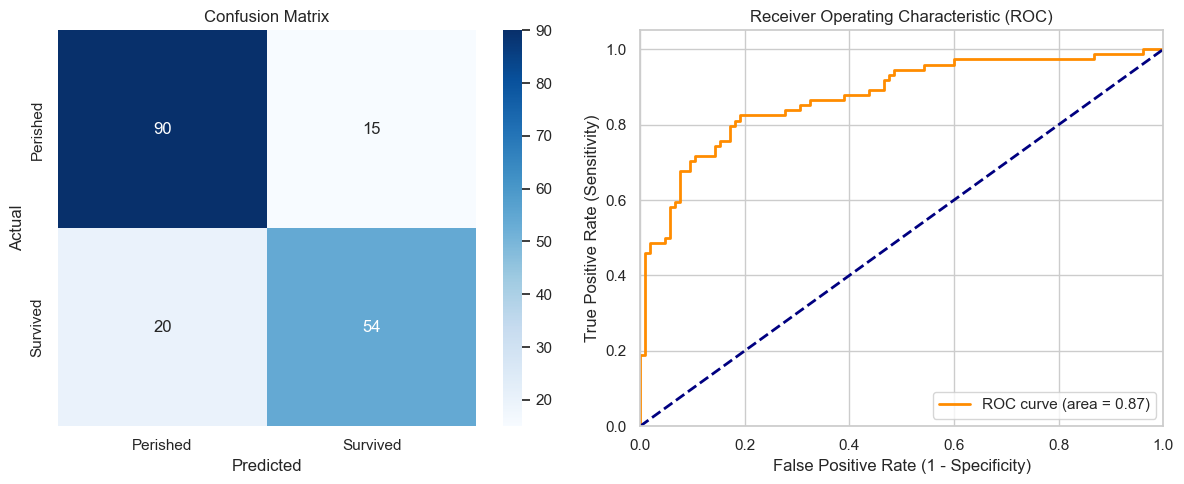

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate Predictions
best_model = models["Logistic Regression"]
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# 2. Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Perished', 'Survived'], 
            yticklabels=['Perished', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# 4. ROC Curve (The missing part!)
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [68]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# 1. Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],      
    'learning_rate': [0.05, 0.1],    
    'max_depth': [3, 4, 5],          
    'subsample': [0.8, 1.0]          
}

# 2. Initialize the model
gb = GradientBoostingClassifier(random_state=42)

# 3. Initialize GridSearchCV
# FIX: n_jobs=1 prevents the '_posixsubprocess' error on Windows
grid_search = GridSearchCV(
    estimator=gb, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=1,  
    scoring='accuracy', 
    verbose=1
)

# 4. Fit the grid search to the scaled training data
print("--- Starting Grid Search (Sequential Mode) ---")
grid_search.fit(X_train_scaled, y_train)

# 5. Get the best results
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Grid Search Accuracy: {grid_search.best_score_:.4f}")

# 6. Extract the final optimized model
tuned_model = grid_search.best_estimator_

# --- 🔟 CROSS-VALIDATION (Validating Model Stability) ---

# We scale the full feature set to check overall consistency
X_scaled = scaler.fit_transform(X)

# Perform 5-Fold Cross-Validation on the tuned model
cv_scores = cross_val_score(tuned_model, X_scaled, y, cv=5)

print("\n--- Final Cross-Validation Results ---")
print(f"Scores for each fold: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

--- Starting Grid Search (Sequential Mode) ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Grid Search Accuracy: 0.8385

--- Final Cross-Validation Results ---
Scores for each fold: [0.82681564 0.81460674 0.85393258 0.81460674 0.85393258]
Mean Accuracy: 0.8328
Standard Deviation: 0.0178


In [69]:
from sklearn.model_selection import cross_val_score

# 1. Select your best model (e.g., the tuned Gradient Boosting)
final_model = grid_search.best_estimator_

# 2. Run 5-fold cross-validation on the full scaled training data
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, cv=5)

# 3. Output results
print(f"Scores for each fold: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Scores for each fold: [0.81818182 0.86013986 0.82394366 0.83098592 0.85915493]
Mean Accuracy: 0.8385
Standard Deviation: 0.0178


In [70]:
# Assuming 'final_model' is your best tuned model and 'X_test' is your testing set
y_pred = final_model.predict(X_test_scaled)

# Create a results dataframe
results_df = X_test.copy()
results_df['Predicted_Survival'] = y_pred
results_df['Survival_Status'] = results_df['Predicted_Survival'].map({1: 'Survived', 0: 'Perished'})

print("✅ Prediction DataFrame Created.")

✅ Prediction DataFrame Created.


In [71]:
# --- 1. Filter for 1st Class Passengers ---
# If Pclass_1 exists, use it. Otherwise, 1st class are those where Pclass_2 and Pclass_3 are both 0.
if 'Pclass_1' in results_df.columns:
    first_class_preds = results_df[results_df['Pclass_1'] == 1]
elif 'Pclass_2' in results_df.columns and 'Pclass_3' in results_df.columns:
    # Logic: If they aren't in Class 2 or 3, they must be in Class 1
    first_class_preds = results_df[(results_df['Pclass_2'] == 0) & (results_df['Pclass_3'] == 0)]
else:
    # If the column is still just named 'Pclass'
    first_class_preds = results_df[results_df['Pclass'] == 1]

print(f"✅ Total 1st Class Predictions: {len(first_class_preds)}")
display(first_class_preds.head())

# --- 2. Filter by Age Group (20-30) ---
age_filter = results_df[(results_df['Age'] >= 20) & (results_df['Age'] <= 30)]
print(f"✅ Total Passengers (Age 20-30): {len(age_filter)}")

# --- 3. Filter by Gender (Female) ---
# Check if your column is 'Sex' or 'Sex_1' or 'Sex_female'
female_col = 'Sex' if 'Sex' in results_df.columns else 'Sex_1' 
female_preds = results_df[results_df[female_col] == 1]
print(f"✅ Total Female Predictions: {len(female_preds)}")

✅ Total 1st Class Predictions: 53


,Sex,Age,Fare,FamilySize,IsAlone,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Predicted_Survival,Survival_Status
290,1,26.0,78.8500,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,Survived
136,1,19.0,26.2833,3,0,0,1,0,0,0,0,1,0,0,0,0,0,1,Survived
137,0,37.0,53.1000,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,Perished
853,1,16.0,39.4000,2,0,0,1,0,0,0,0,1,0,0,0,0,0,1,Survived
621,0,42.0,52.5542,2,0,0,1,0,0,0,0,1,0,0,0,0,0,1,Survived


✅ Total Passengers (Age 20-30): 71
✅ Total Female Predictions: 69


In [72]:
import joblib

# Replace 'grid_search.best_estimator_' with whatever your trained model variable is named
# If you used 'best_model', use that instead.
if 'grid_search' in globals():
    joblib.dump(grid_search.best_estimator_, 'titanic_model.pkl')
    print("✅ Model exported successfully!")

# Replace 'scaler' with your fitted StandardScaler object name
if 'scaler' in globals():
    joblib.dump(scaler, 'scaler.pkl')
    print("✅ Scaler exported successfully!")

✅ Model exported successfully!
✅ Scaler exported successfully!
